In [17]:
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

# Confirm that we're using Python 3
assert sys.version_info.major == 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'
print('TensorFlow version: {}'.format(tf.__version__))

TensorFlow version: 2.3.0


# Load fashion mnist data

In [18]:
fashionmnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashionmnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))


train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


# Build version 1 of the fashion mnist image classification model

In [10]:
model1 = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model1.summary()

epochs = 5

compilation_args = {
    "optimizer": 'adam',
    "loss": 'sparse_categorical_crossentropy',
    "metrics": ['accuracy']
}

model1.compile(**compilation_args)
model1.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model1.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

# save it
MODEL_DIR='./models/1'
model1.save(MODEL_DIR)

# reconstruct it by loading
reconstructed_model1 = keras.models.load_model(MODEL_DIR)
# compile the loaded model
reconstructed_model1.compile(**compilation_args)

# ensure loaded model returns same predictions as saved model
reconstructed_test_loss, reconstructed_test_acc = reconstructed_model1.evaluate(test_images, test_labels)
np.testing.assert_allclose(
    model1.predict(test_images), reconstructed_model1.predict(test_images)
)

print('\nReconstructed test accuracy: {}'.format(reconstructed_test_acc))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 8)         80        
_________________________________________________________________
flatten_2 (Flatten)          (None, 1352)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                13530     
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5431 - accuracy: 0.8108
Epoch 2/5
1875/1875 [==============================] - 2s 987us/step - loss: 0.4106 - accuracy: 0.8553
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3764 - accuracy: 0.8688
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 

# Build version 2 of the fashion mnist image classification model

In [11]:
model2 = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=16, kernel_size=4, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model2.summary()

epochs = 5

model2.compile(**compilation_args)
model2.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model2.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

# save it
MODEL_DIR='./models/2'
model2.save(MODEL_DIR)

# reconstruct it by loading
reconstructed_model2 = keras.models.load_model(MODEL_DIR)
# compile the loaded model
reconstructed_model2.compile(**compilation_args)

# ensure loaded model returns same predictions as saved model
reconstructed_test_loss, reconstructed_test_acc = reconstructed_model2.evaluate(test_images, test_labels)
np.testing.assert_allclose(
    model2.predict(test_images), reconstructed_model2.predict(test_images)
)

print('\nReconstructed test accuracy: {}'.format(reconstructed_test_acc))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 13, 13, 16)        272       
_________________________________________________________________
flatten_3 (Flatten)          (None, 2704)              0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                27050     
Total params: 27,322
Trainable params: 27,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5181 - accuracy: 0.8187
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3849 - accuracy: 0.8658
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3393 - accuracy: 0.8807
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.

# Build version 3 of the fashion mnist image classification model

In [12]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(28, 28, 1)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(32, (2, 2), activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.Dropout(rate = 0.5))
model3.add(layers.Dense(10, activation=tf.nn.softmax))

model3.summary()

epochs = 20

model3.compile(**compilation_args)
model3.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model3.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

# save it
MODEL_DIR='./models/3'
model3.save(MODEL_DIR)

# reconstruct it by loading
reconstructed_model3 = keras.models.load_model(MODEL_DIR)
# compile the loaded model
reconstructed_model3.compile(**compilation_args)

# ensure loaded model returns same predictions as saved model
reconstructed_test_loss, reconstructed_test_acc = reconstructed_model3.evaluate(test_images, test_labels)
np.testing.assert_allclose(
    model3.predict(test_images), reconstructed_model3.predict(test_images)
)

print('\nReconstructed test accuracy: {}'.format(reconstructed_test_acc))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        4128      
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                46090     
Total params: 50,378
Trainable params: 50,378
Non-trainable params: 0
__________________________________________________

# Create container images for the three model versions

### These models are already dockerized and available from docker hub as pre-built images and are named/tagged as iter8/fashionmnist:v1, iter8/fashionmnist:v2, and iter8/fashionmnist:v3 respectively.

### For building your own images from these models, refer to instructions on https://github.com/iter8-tools/mlops.


# Serve the model images on a kubernetes cluster
### For deploying these on kubernetes on a kubernetes cluster, refer to instructions on https://github.com/iter8-tools/mlops.

# Send image traffic to the deployed model

In [19]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

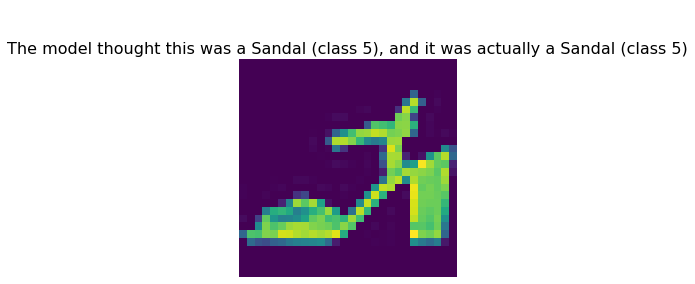

In [23]:
import json
import requests
import random
import time

# Depending upon where you are running the model, you may need to change the gateway_url below

# 1. If you are serving the model on localhost (e.g., as a local docker container)
# use gateway_url = "http://localhost" below

# 2. If you are serving the model on minikube based kubernetes cluster with Istio,
# use ingress_host = !(minikube ip)
# use ingress_port = !(kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.spec.ports[?(@.name=="http2")].nodePort}')

# 3. If you are serving the model on any other kubernetes cluster with Istio, 
# refer to instructions here on determining your gateway_url
# https://istio.io/latest/docs/setup/getting-started/#determining-the-ingress-ip-and-ports

ingress_host_list = !(minikube ip)
ingress_port_list = !(kubectl -n istio-system get service istio-ingressgateway -o jsonpath='{.spec.ports[?(@.name=="http2")].nodePort}')
gateway_url = "http://{}:{}".format(ingress_host_list[0], ingress_port_list[0])
model_url = "{}/v1/models/fashionmnist:predict".format(gateway_url)

rando = random.randint(0,len(test_images)-1)
data = json.dumps({"signature_name": "serving_default", "instances": test_images[rando:rando + 1].tolist()})
headers = {"content-type": "application/json"}
json_response = requests.post(model_url, data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(rando, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[rando]], test_labels[rando]))

In [24]:
for i in range(1000): # send a image at random to the model server and get back the prediction; do it a 1000 times.
    rando = random.randint(0,len(test_images)-1)
    data = json.dumps({"signature_name": "serving_default", "instances": test_images[rando:rando + 1].tolist()})
    headers = {"content-type": "application/json"}
    json_response = requests.post(model_url, data=data, headers=headers)
    predictions = json.loads(json_response.text)['predictions']

    print('The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
      class_names[np.argmax(predictions[0])], np.argmax(predictions[0]), class_names[test_labels[rando]], test_labels[rando]))

    time.sleep(1.0)

The model thought this was a Ankle boot (class 9), and it was actually a Ankle boot (class 9)
The model thought this was a Coat (class 4), and it was actually a Coat (class 4)
The model thought this was a T-shirt/top (class 0), and it was actually a T-shirt/top (class 0)
The model thought this was a Sandal (class 5), and it was actually a Sandal (class 5)
The model thought this was a Sneaker (class 7), and it was actually a Sneaker (class 7)
The model thought this was a Dress (class 3), and it was actually a Dress (class 3)


KeyboardInterrupt: 